In [1]:
outdir = '../output'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plot_tools as pt
import data_tools as dt

In [3]:
idx = pd.IndexSlice

In [4]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Load Data

In [5]:
df_world = dt.load_country()

In [6]:
df_state = dt.load_state()

In [7]:
df_county = dt.load_county()

### Countries

In [8]:
world_names = {
    'USA': 'USA',
    'ITA': 'Italy',
    'DEU': 'Germany',
    'GBR': 'UK'
}

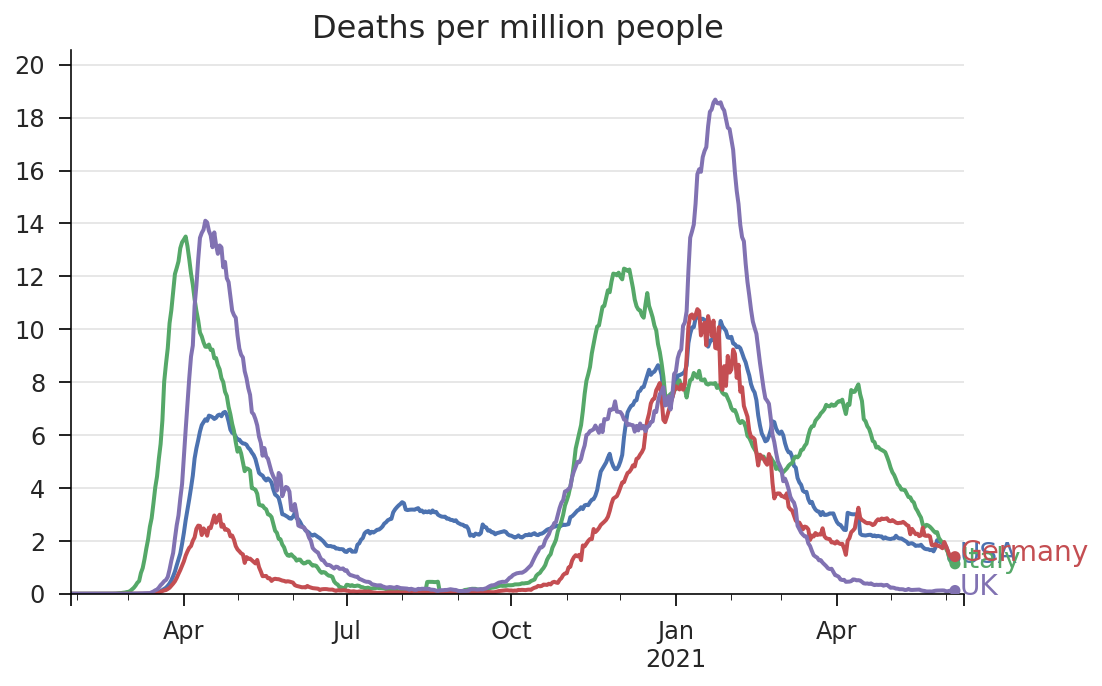

In [9]:
fig, ax = pt.plot_progress(df_world['deaths_pc'], names=world_names)
ax.set_xlabel('')
ax.set_title(f'Deaths per million people')
fig.savefig(f'{outdir}/country_deaths.svg', bbox_inches='tight')

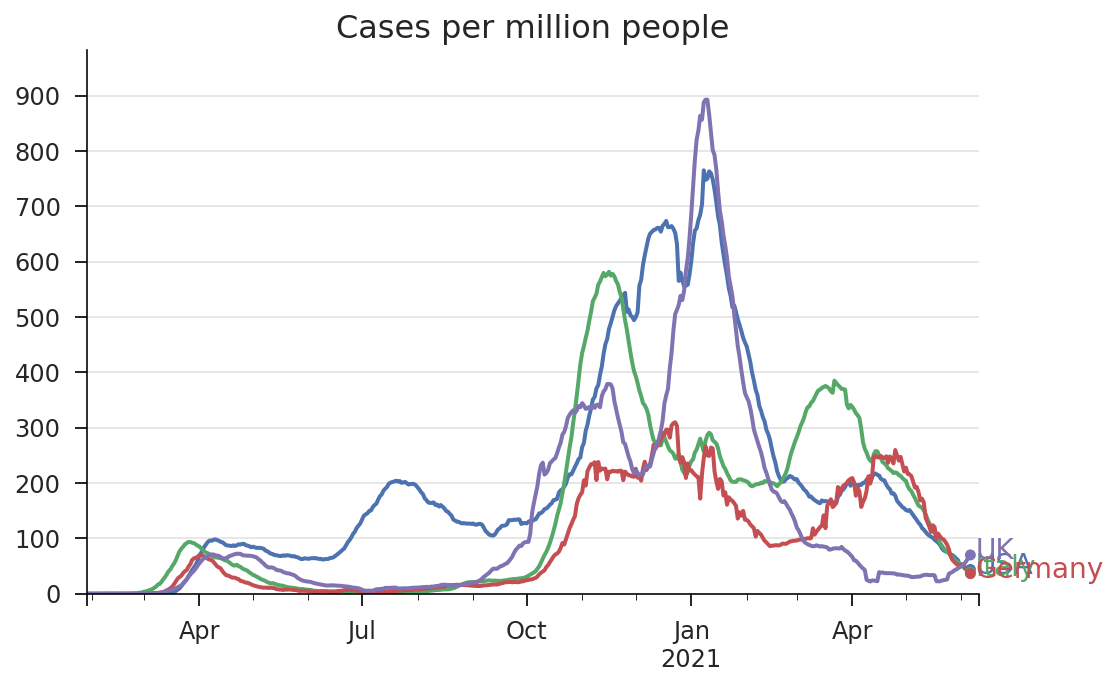

In [10]:
fig, ax = pt.plot_progress(df_world['cases_pc'], names=world_names)
ax.set_xlabel('')
ax.set_title(f'Cases per million people')
fig.savefig(f'{outdir}/country_cases.svg', bbox_inches='tight')

### States

In [11]:
state_names = ['CA', 'PA', 'IL', 'WI', 'AZ']

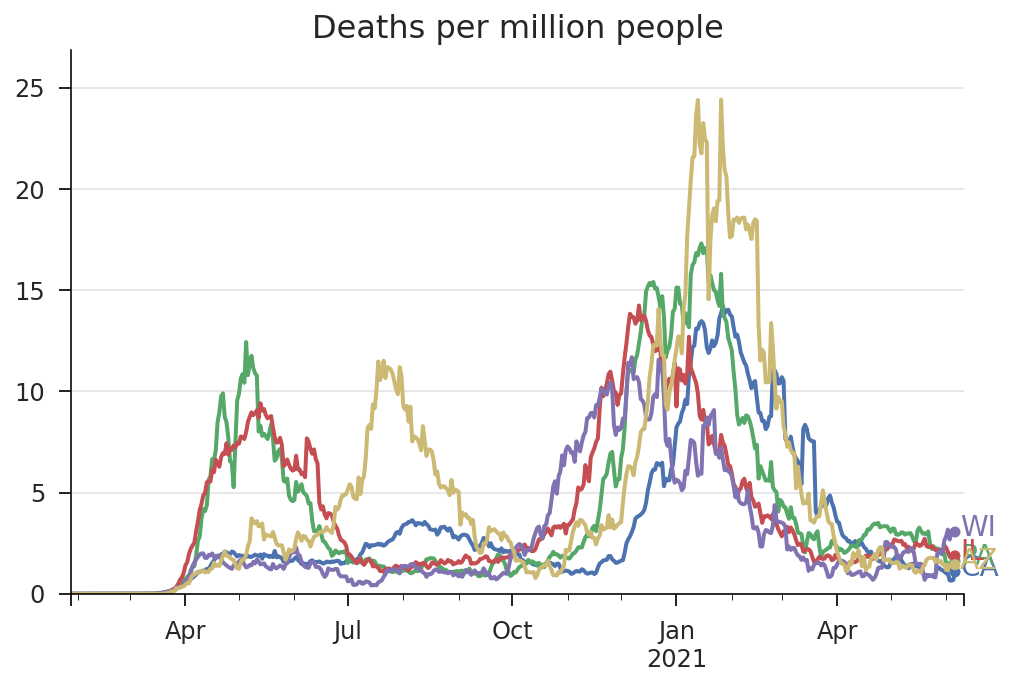

In [12]:
fig, ax = pt.plot_progress(df_state['deaths_pc'], names=state_names)
ax.set_xlabel('')
ax.set_title(f'Deaths per million people')
fig.savefig(f'{outdir}/state_deaths.svg', bbox_inches='tight')

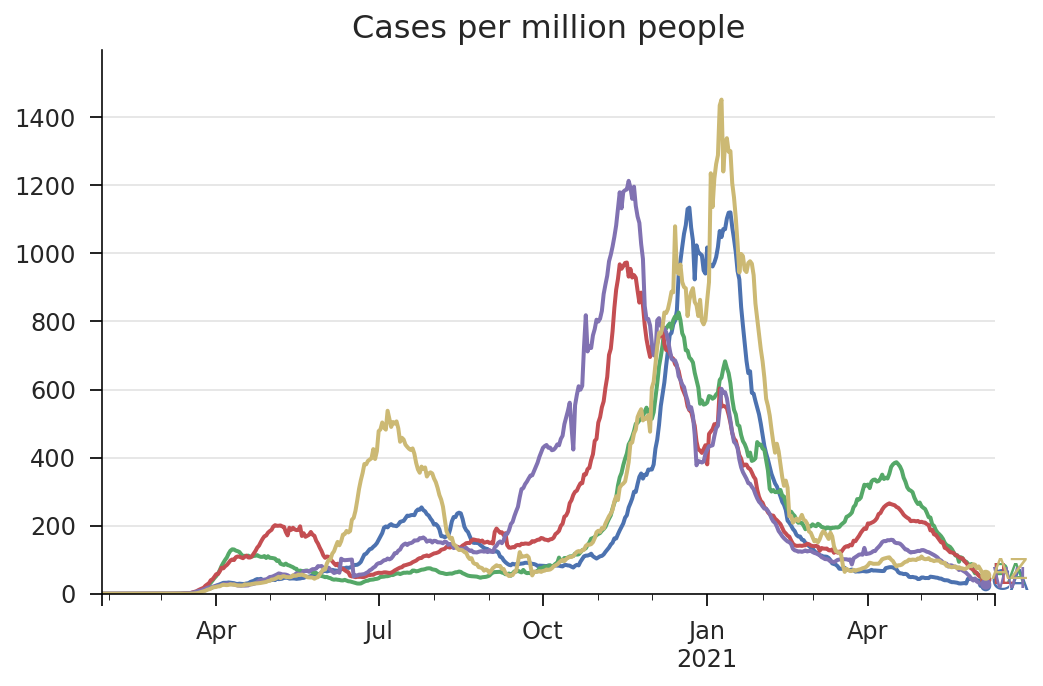

In [13]:
fig, ax = pt.plot_progress(df_state['cases_pc'], names=state_names)
ax.set_xlabel('')
ax.set_title(f'Cases per million people')
fig.savefig(f'{outdir}/state_cases.svg', bbox_inches='tight')

### Counties

In [14]:
county_names = [
    'Los Angeles, CA',
    'Allegheny, PA',
    'Erie, NY',
    'King, WA',
    'Philadelphia, PA'
]

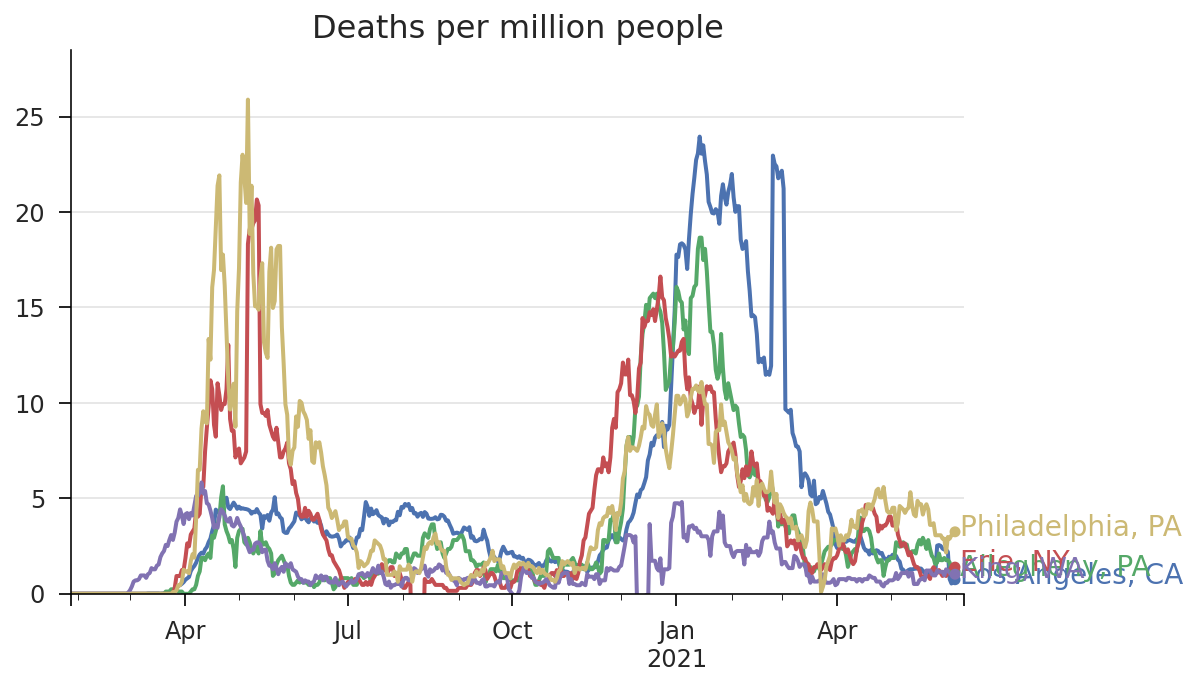

In [15]:
fig, ax = pt.plot_progress(df_county['deaths_pc'], names=county_names)
ax.set_xlabel('')
ax.set_title(f'Deaths per million people')
fig.savefig(f'{outdir}/county_deaths.svg', bbox_inches='tight')

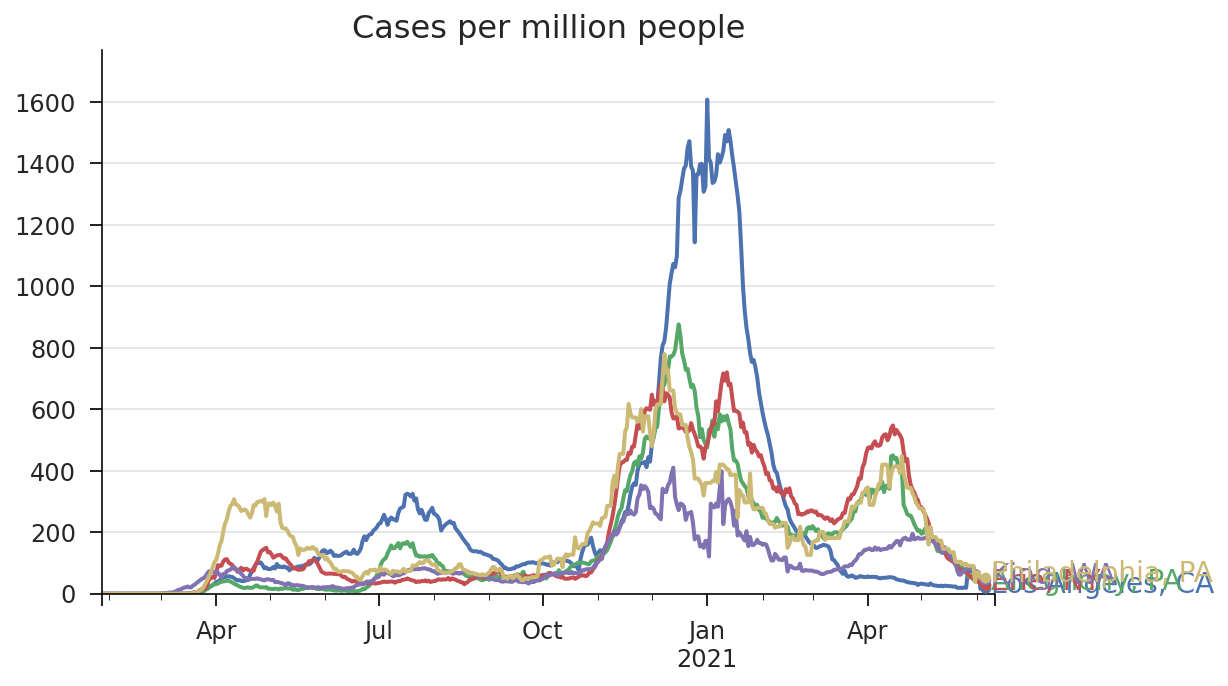

In [16]:
fig, ax = pt.plot_progress(df_county['cases_pc'], names=county_names)
ax.set_xlabel('')
ax.set_title(f'Cases per million people')
fig.savefig(f'{outdir}/county_cases.svg', bbox_inches='tight')

### EU

In [19]:
df_eu

,cases_cum,cases_cum_pc,cases,cases_pc,deaths_cum,deaths_cum_pc,deaths,deaths_pc,cases_cum,cases_cum_pc,...,deaths,deaths_pc,cases_cum,cases_cum_pc,cases,cases_pc,deaths_cum,deaths_cum_pc,deaths,deaths_pc
country_code,AUS,AUS,AUS,AUS,AUS,AUS,AUS,AUS,BEL,BEL,...,ESP,ESP,SWE,SWE,SWE,SWE,SWE,SWE,SWE,SWE
2020-01-22,0,0.000000e+00,NaN,NaN,0,0.000000,NaN,NaN,0,0.000000,...,NaN,NaN,0,0.000000,NaN,NaN,0,0.000000,NaN,NaN
2020-01-23,0,0.000000e+00,0.0,0.000000e+00,0,0.000000,0.0,0.0,0,0.000000,...,0.0,0.000000e+00,0,0.000000,0.0,0.000000,0,0.000000,0.0,0.000000
2020-01-24,0,0.000000e+00,0.0,0.000000e+00,0,0.000000,0.0,0.0,0,0.000000,...,0.0,0.000000e+00,0,0.000000,0.0,0.000000,0,0.000000,0.0,0.000000
2020-01-25,0,0.000000e+00,0.0,0.000000e+00,0,0.000000,0.0,0.0,0,0.000000,...,0.0,0.000000e+00,0,0.000000,0.0,0.000000,0,0.000000,0.0,0.000000
2020-01-26,4,1.577019e-07,4.0,1.577019e-07,0,0.000000,0.0,0.0,0,0.000000,...,0.0,0.000000e+00,0,0.000000,0.0,0.000000,0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-02,30137,1.188166e-03,13.0,5.125313e-07,910,0.000036,0.0,0.0,1065358,0.092768,...,66.0,1.401965e-06,1068473,0.103882,0.0,0.000000,14451,0.001405,0.0,0.000000
2021-06-03,30141,1.188323e-03,4.0,1.577019e-07,910,0.000036,0.0,0.0,1066957,0.092908,...,0.0,0.000000e+00,1076993,0.104710,8520.0,0.000828,14512,0.001411,61.0,0.000006
2021-06-04,30157,1.188954e-03,16.0,6.308077e-07,910,0.000036,0.0,0.0,1068406,0.093034,...,146.0,3.101317e-06,1078062,0.104814,1069.0,0.000104,14523,0.001412,11.0,0.000001


In [17]:
eu_codes = [
    'AUS', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST',
    'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA',
    'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK',
    'SVN', 'ESP', 'SWE'
]
df_eu = df_world.loc[:, idx[:, eu_codes]]

In [29]:
iso_info = pd.read_csv(f'../data/meta/country_info.csv', dtype={'population': 'Int64'})
iso_pop = iso_info.set_index('country_code')['population']
iso_pop = iso_pop.groupby('country_code').first()
eu_pop = iso_pop.loc[eu_codes].sum()

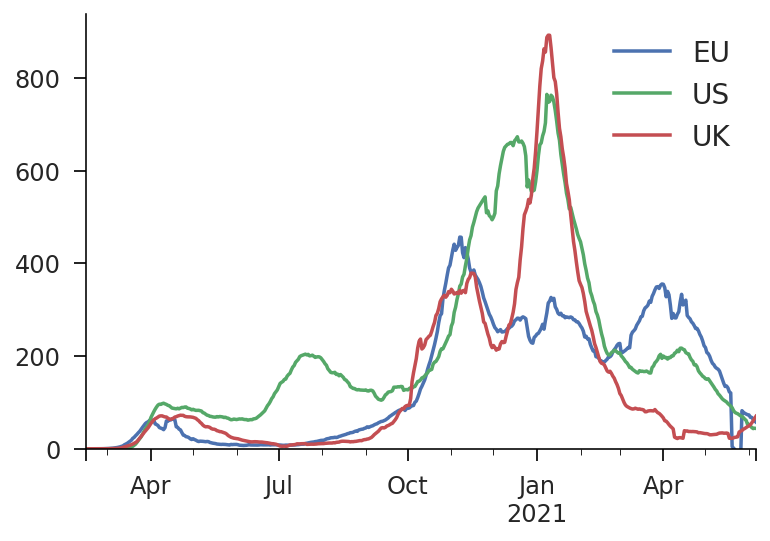

In [31]:
df_cases = pd.DataFrame({
    'EU': df_eu['cases'].sum(axis=1)/eu_pop,
    'US': df_world['cases_pc']['USA'],
    'UK': df_world['cases_pc']['GBR']
})
(1e6*df_cases).rolling(7).mean().loc['2020-02-15':].plot(ylim=(0, None));

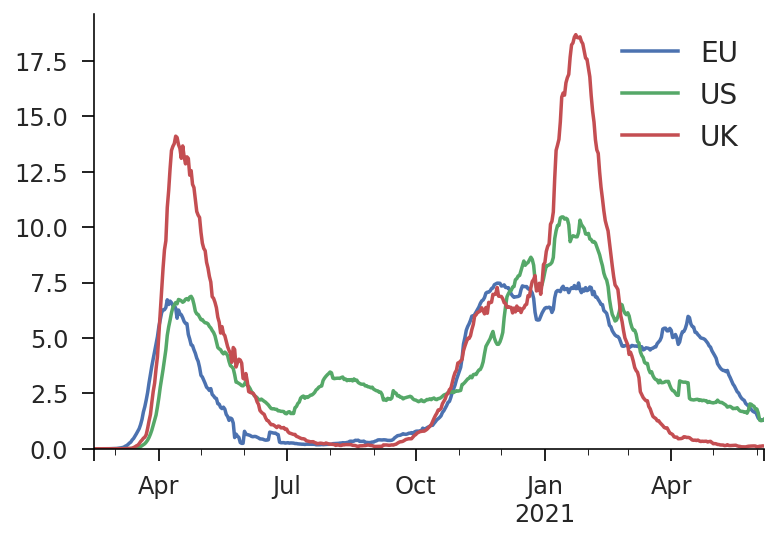

In [32]:
df_cases = pd.DataFrame({
    'EU': df_eu['deaths'].sum(axis=1)/eu_pop,
    'US': df_world['deaths_pc']['USA'],
    'UK': df_world['deaths_pc']['GBR']
})
(1e6*df_cases).rolling(7).mean().loc['2020-02-15':].plot(ylim=(0, None));

### Testing

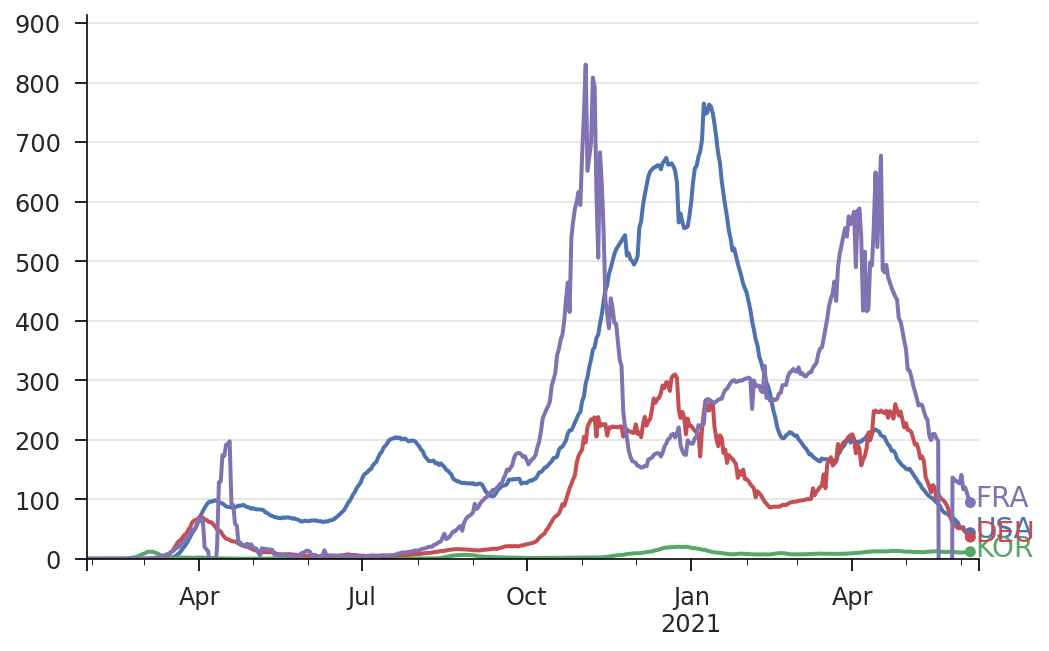

In [33]:
fig, ax = pt.plot_progress(df_world['cases_pc'], names=['USA', 'KOR', 'DEU', 'FRA'], per=1e6)

/media/wintermute/work/coviz/code/plot_tools.py:12: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)/np.log(base)


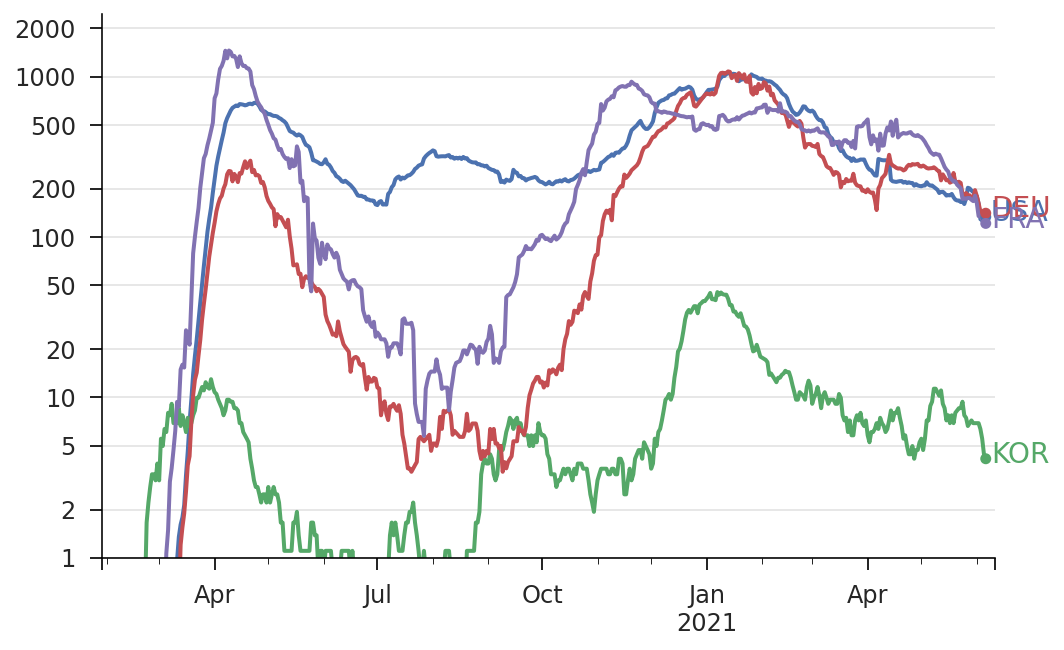

In [34]:
fig, ax = pt.plot_progress(df_world['deaths_pc'], names=['USA', 'KOR', 'DEU', 'FRA'], log=True, per=1e8)

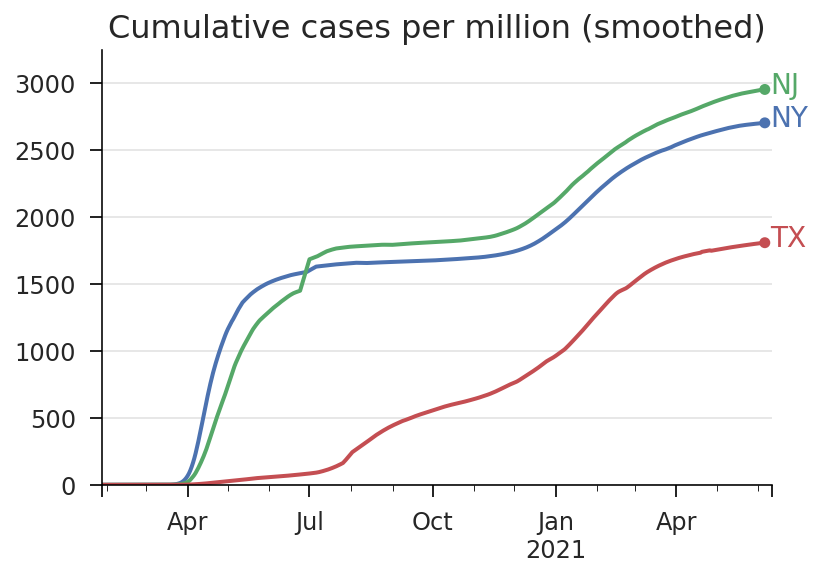

In [35]:
fig, ax = pt.plot_progress(
    df_state['deaths_pc'], names=['NY', 'NJ', 'TX'],
    log=False, cumul=True,
    per=1e6, figsize=(6, 4),
)
ax.set_xlabel('')
ax.set_title('Cumulative cases per million (smoothed)');
# fig.savefig(f'/home/doug/mountain_west.png', dpi=300, bbox_inches='tight')

## Tracker

In [36]:
strip_county = lambda s: s.removesuffix('County').removesuffix('Parish').strip()

In [37]:
county_stats = dt.load_county_stats()
county_stats['short_name'] = county_stats['county_name'].apply(strip_county)
county_stats['full_name'] = county_stats['short_name'] + ', ' + county_stats['state_code']
county_stats = county_stats.set_index('full_name')
county_stats = county_stats.drop('Oglala Lakota, SD')

In [38]:
case_smooth = df_county['cases_pc'].rolling(7).mean()
case_track = pd.DataFrame({
    'pop': county_stats['pop'],
    'state': county_stats['state_code'],
    'case_base': case_smooth.iloc[-15],
    'case_next': case_smooth.iloc[-1],
})
case_track['tot_base'] = case_track['pop']*case_track['case_base']
case_track['tot_next'] = case_track['pop']*case_track['case_next']
case_track['case_jump'] = (
    pt.log1(case_track['case_next'], base=10) - pt.log1(case_track['case_base'], base=10)
)
case_track['lpop'] = pt.log1(case_track['pop'].astype(np.float), base=10)

/home/doug/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/doug/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [39]:
state_grp = case_track.groupby('state')
state_track = state_grp[['tot_base', 'tot_next']].sum().div(state_grp['pop'].sum(), axis=0)
state_track['tot_jump'] = pt.log1(state_track['tot_next'], base=10) - pt.log1(state_track['tot_base'], base=10)

/home/doug/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


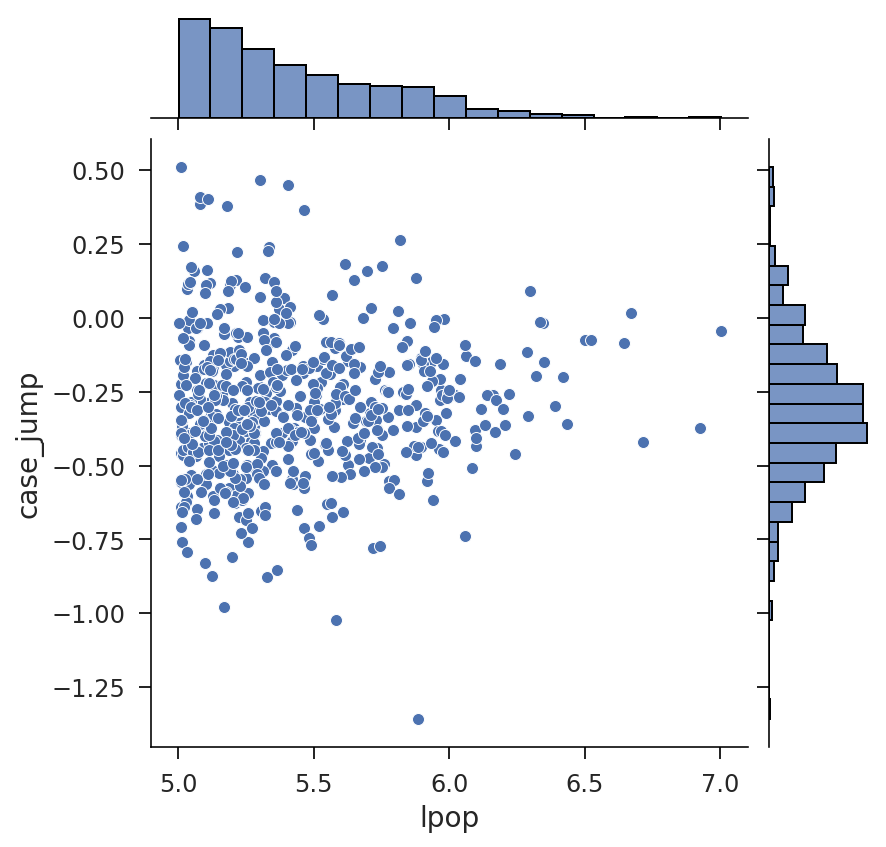

In [41]:
case_sel = case_track.query('pop > 100000 and case_jump > -2.5')
sns.jointplot('lpop', 'case_jump', data=case_sel);

In [42]:
case_track.query('pop > 200000')['case_jump'].sort_values(ascending=False).head(30)

full_name
Hawaii, HI           0.467680
Weber, UT            0.449969
Greene, MO           0.363277
Jefferson, AL        0.263797
Doña Ana, NM         0.238882
Shelby, AL           0.225309
Mobile, AL           0.180208
Williamson, TX       0.174437
Sonoma, CA           0.158797
San Joaquin, CA      0.135934
Mohave, AZ           0.135513
Solano, CA           0.126403
Montgomery, AL       0.120936
Smith, TX            0.092146
Bexar, TX            0.089632
Brazoria, TX         0.076492
Benton, WA           0.069197
Clay, MO             0.065679
Richmond city, VA    0.052178
St. Tammany, LA      0.036984
Spokane, WA          0.032039
Hinds, MS            0.029455
Tulsa, OK            0.022276
Yakima, WA           0.016599
Harris, TX           0.014858
Hamilton, IN         0.010077
Clark, WA           -0.001121
Marion, IN          -0.002917
Douglas, CO         -0.003303
Whatcom, WA         -0.004799
Name: case_jump, dtype: float64

In [52]:
state_track = case_track.groupby('state')[['tot_base', 'tot_next']].sum()
(state_track['tot_next']/state_track['tot_base']).sort_values(ascending=False)

state
AR    1.865406e+00
TX    1.470087e+00
MI    1.454032e+00
HI    1.258865e+00
ME    1.208245e+00
LA    1.202914e+00
NE    1.155283e+00
SD    1.131165e+00
NJ    1.112508e+00
AL    1.097553e+00
VT    1.086575e+00
ID    1.083584e+00
CO    1.077662e+00
DC    1.050198e+00
AK    1.023290e+00
MN    9.951402e-01
IL    9.552952e-01
MD    9.527039e-01
NY    9.454124e-01
CT    9.378817e-01
PA    9.095140e-01
RI    8.950298e-01
FL    8.909574e-01
NV    8.756115e-01
DE    8.729133e-01
NM    8.531436e-01
ND    8.522895e-01
WI    8.520825e-01
GA    8.325918e-01
MS    8.284175e-01
MA    8.234537e-01
WV    8.213256e-01
WA    8.169720e-01
IN    8.000285e-01
AZ    7.936580e-01
OH    7.845581e-01
OK    7.826519e-01
MT    7.483246e-01
MO    7.404779e-01
TN    7.268012e-01
VA    7.105227e-01
KY    6.936463e-01
WY    6.934673e-01
OR    6.903250e-01
CA    6.483818e-01
UT    6.465485e-01
NC    6.397258e-01
NH    5.841014e-01
SC    5.174505e-01
KS    4.379167e-01
IA    2.352976e-15
dtype: float64

### PWT

In [82]:
import mectools.plot as mp
import plotbot.client as pb

In [54]:
pwt0 = pd.read_excel('../data/pwt/pwt100.xlsx', sheet_name='Data', engine='openpyxl')
pwt = pwt0.pivot('year', 'countrycode')

In [64]:
gdp_pc = pwt['rgdpna']/pwt['pop']
gdp_pc_2019 = gdp_pc.loc[2019]
popul_2019 = pwt['pop'].loc[2019]
deaths_end = 1e6*df_world['deaths_pc'].iloc[-1]

<ipython-input-150-9e88bb0c4f09>:6: RuntimeWarning: divide by zero encountered in log
  df_comp = np.log(df_comp)


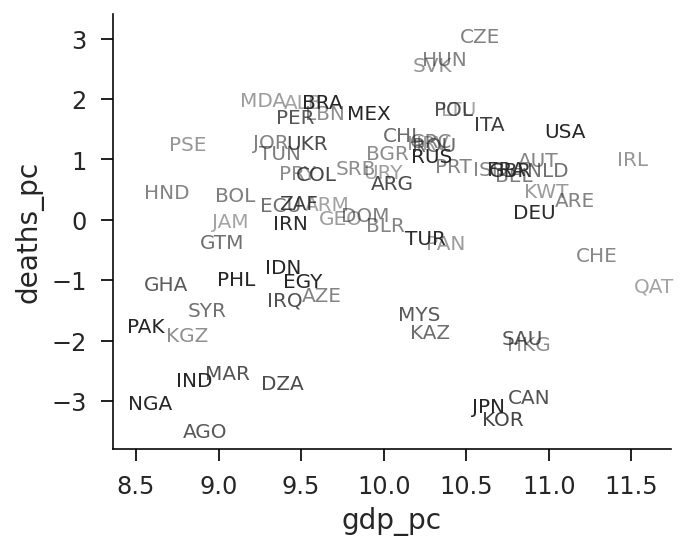

In [150]:
df_comp = pd.DataFrame({
    'popul': popul_2019,
    'deaths_pc': deaths_end,
    'gdp_pc': gdp_pc_2019,
})
df_comp = np.log(df_comp)
df_comp['alpha'] = np.minimum(1, 3*(popul_2019/np.sum(popul_2019))**0.25)
df_sel = df_comp.query('popul > 1 and gdp_pc > 8.5')
mp.scatter_label('gdp_pc', 'deaths_pc', df_sel, alpha='alpha');